### Домашнее задание «Элементарные методы анализа временных рядов»  
Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [2]:
wcDJ = pd.read_csv('weekly-closings-of-the-dowjones-.csv')

In [3]:
wcDJ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Week    162 non-null    object 
 1   Close   162 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.7+ KB


In [4]:
all_series = {'weekly_closings_of_the_dowjones_': wcDJ['Close']}

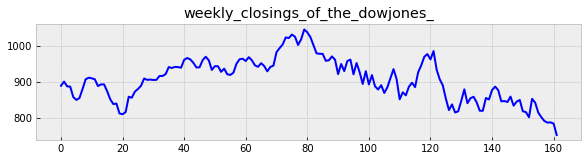

In [5]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (4, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

In [6]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

## Нестационарный ряд  
### Скользящее среднее

In [7]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

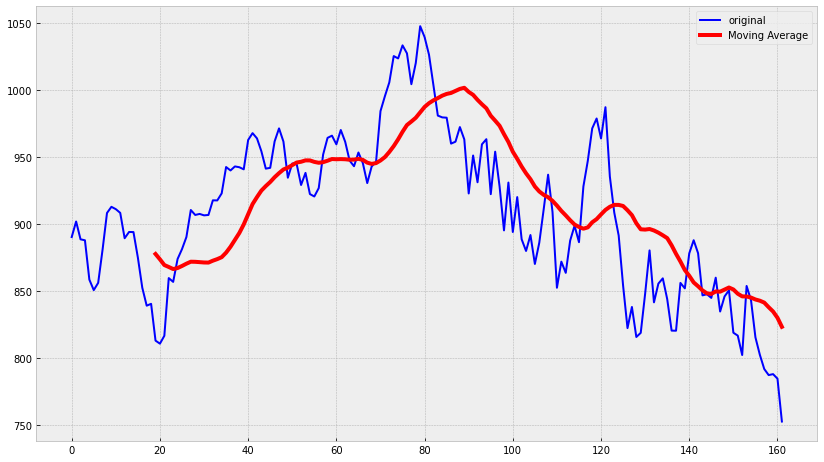

In [8]:
ser = moving_average(wcDJ["Close"], 20)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(wcDJ["Close"], color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

### Взвешенная скользящая средняя

In [9]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

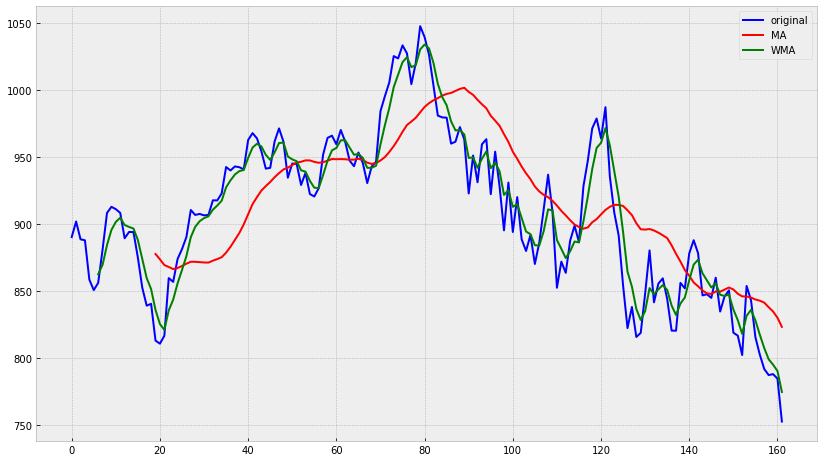

In [10]:
wma = weighted_moving_average(wcDJ["Close"], 7, [1,1,2,3,5,8,13])
ma = moving_average(wcDJ["Close"], 20)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(wcDJ["Close"], color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

### Экспоненциальное сглаживание

In [11]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

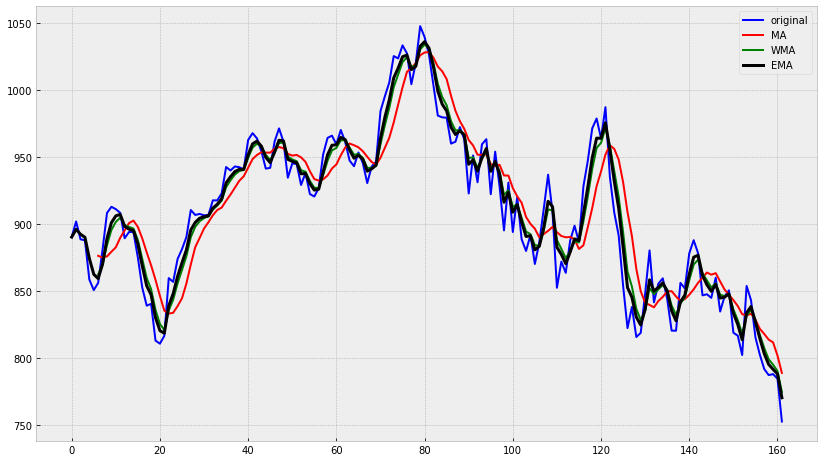

In [12]:
ema = exponential_moving_average(wcDJ["Close"], 0.5)
wma = weighted_moving_average(wcDJ["Close"], 7, [1,1,2,3,5,8,13])
ma = moving_average(wcDJ["Close"], 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(wcDJ["Close"], color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='3', label='EMA')
    plt.legend()

In [13]:
series = all_series["weekly_closings_of_the_dowjones_"]

In [14]:
train, test = series[:81], series[81:]

In [15]:
def mse_ema(X):
    alpha, beta = X
    result = exponential_moving_average(train, alpha)
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [18]:
def plot_ema(alpha, ser=series, ser_to_plot=series):
    dema = exponential_moving_average(ser, alpha)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(ema, color='red', linewidth='4', label='EMA')
        plt.title("alpha={}".format(alpha))
        plt.legend()

In [16]:
opt = minimize(mse_ema, x0=[0, 0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))
alpha_opt= opt.x
print(opt)

      fun: 3642.8895049382713
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([88389.26946737,     0.        ])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])


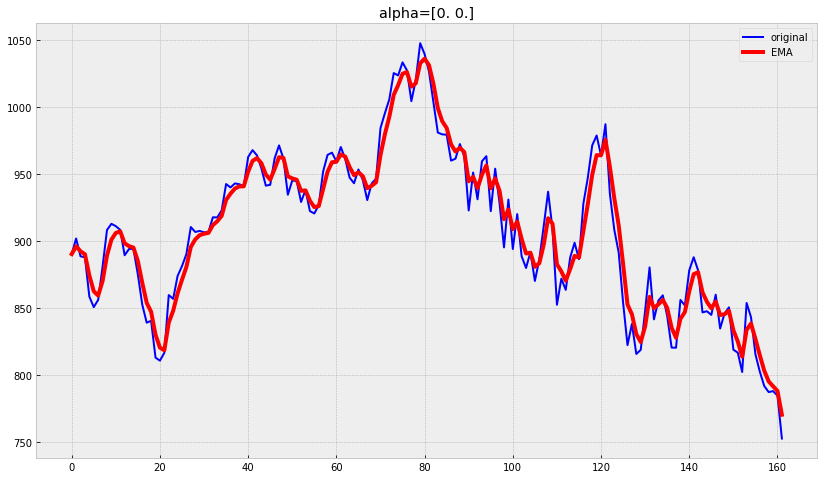

In [20]:
plot_ema(alpha_opt)

### Двойное экспоненциальное сглаживание

In [21]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [39]:
def plot_dema(alpha, beta):
    dema = double_ema(wcDJ["Close"], alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(wcDJ["Close"], color='blue',label='original')
        plt.plot(dema, color='red', linewidth='2', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

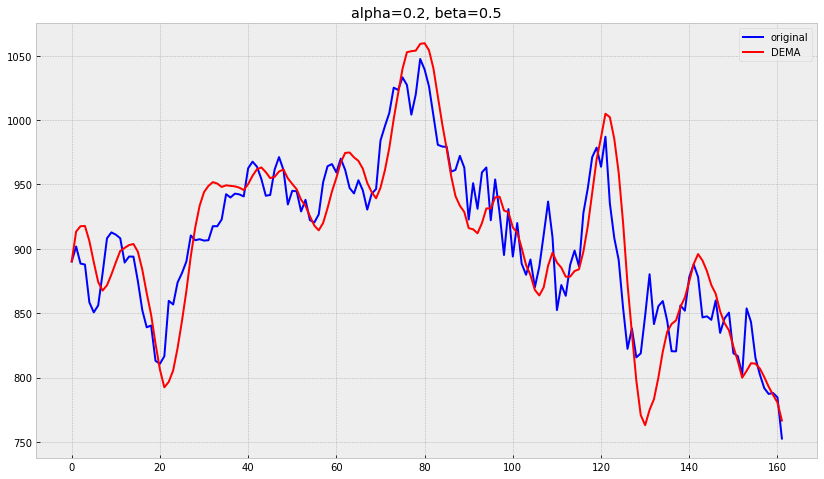

In [51]:
plot_dema(0.2, 0.5)

### Хольт-Винтерс

In [52]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [53]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [54]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [55]:
def plot_tema(alpha, beta, gamma, ser=wcDJ["Close"], ser_to_plot=wcDJ["Close"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='2', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

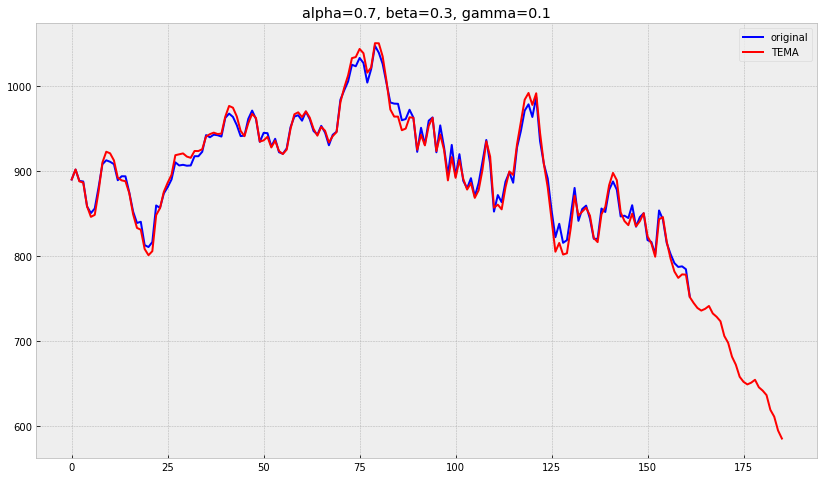

In [56]:
plot_tema(0.7, 0.3, 0.1)

In [59]:
train, test, val = series[:60], series[60:80], series[80:]

In [60]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [61]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [62]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 2290.816515769353
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.33482101e+02, -1.36424205e-04, -0.00000000e+00])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 32
      nit: 7
     njev: 8
   status: 0
  success: True
        x: array([1.        , 0.26532605, 1.        ])


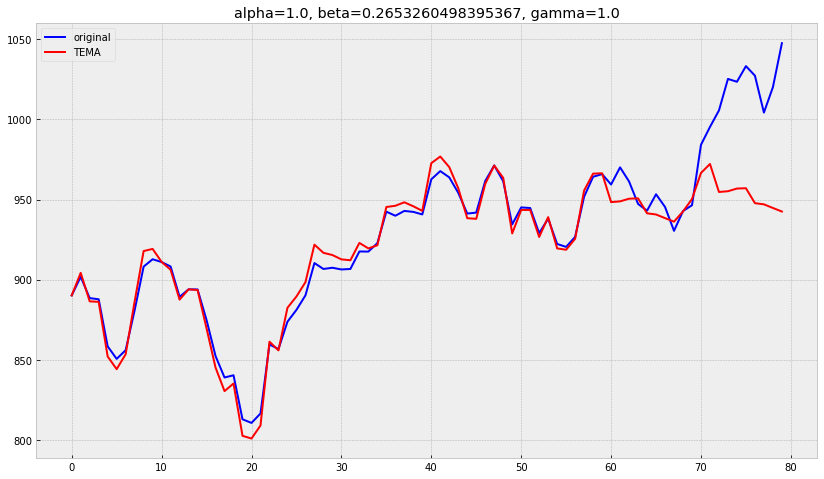

In [63]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:80], n_preds=len(test))

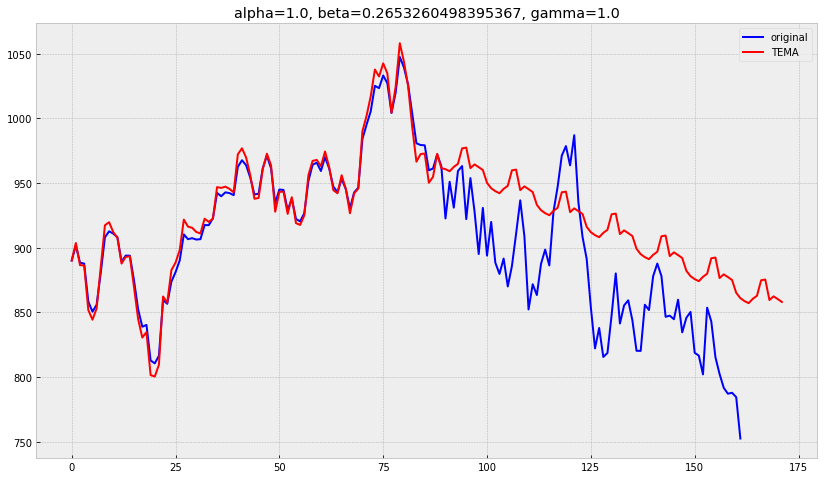

In [64]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series[:90], ser_to_plot=series, n_preds=len(val))

## Стационарный ряд

Results of Dickey-Fuller Test:
Test Statistic                -1.299582e+01
p-value                        2.751609e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


E:\DS\anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


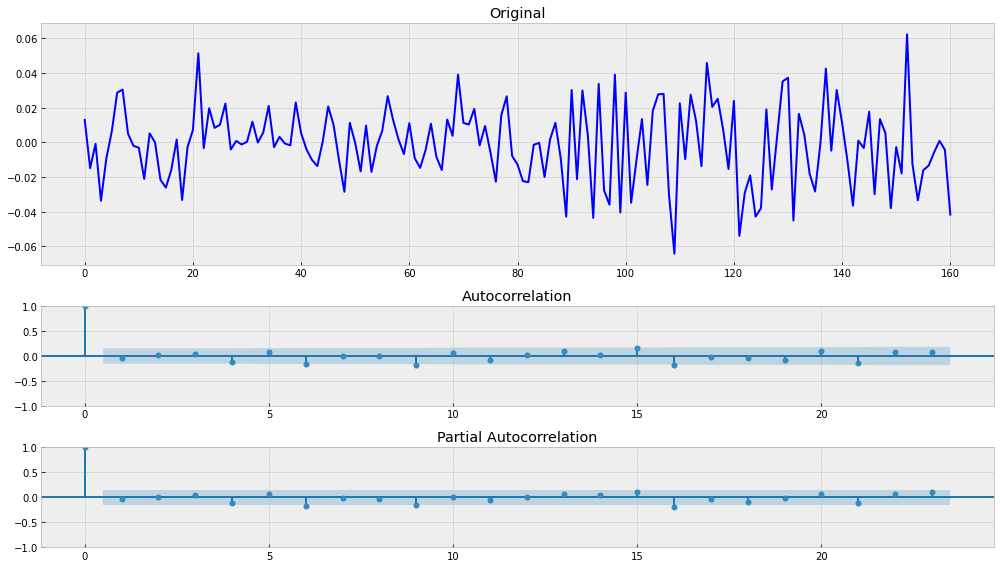

In [65]:
wcDJS = wcDJ['Close']
wcDJS = boxcox(wcDJS, 0)
wcDJS = wcDJS[1:] - wcDJS[:-1]
tsplot(wcDJS)

### Скользящее среднее

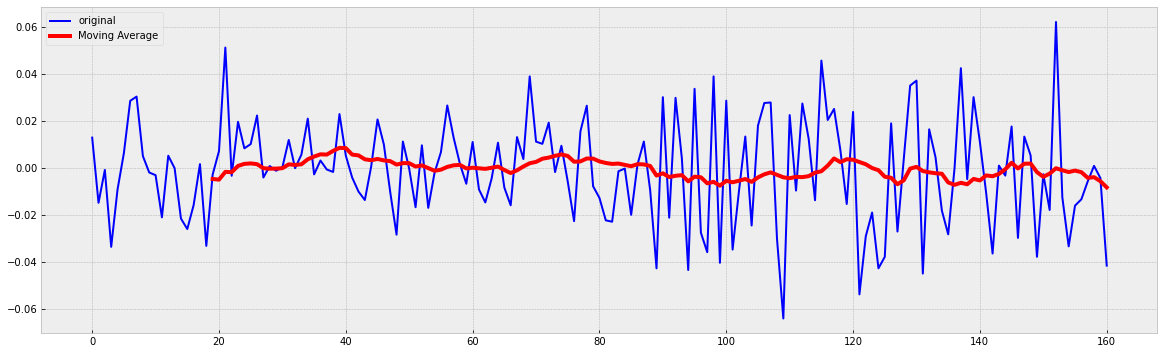

In [66]:
ser = moving_average(wcDJS, 20)
with plt.style.context('bmh'):
    plt.figure(figsize=(20, 6))
    plt.plot(wcDJS, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

### Взвешенная скользящая средняя

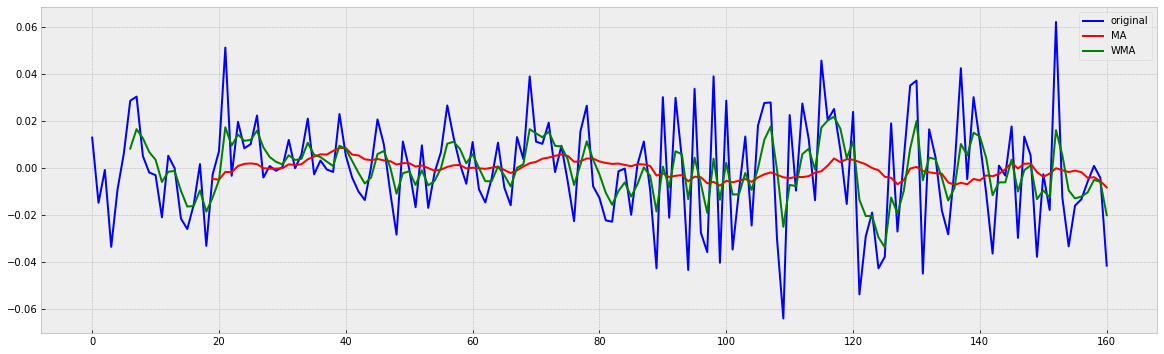

In [67]:
wma = weighted_moving_average(wcDJS, 7, [1,1,2,3,5,8,13]) # Числа Фиббоначи
ma = moving_average(wcDJS, 20)
with plt.style.context('bmh'):
    plt.figure(figsize=(20, 6))
    plt.plot(wcDJS, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

### Экспоненциальное сглаживание

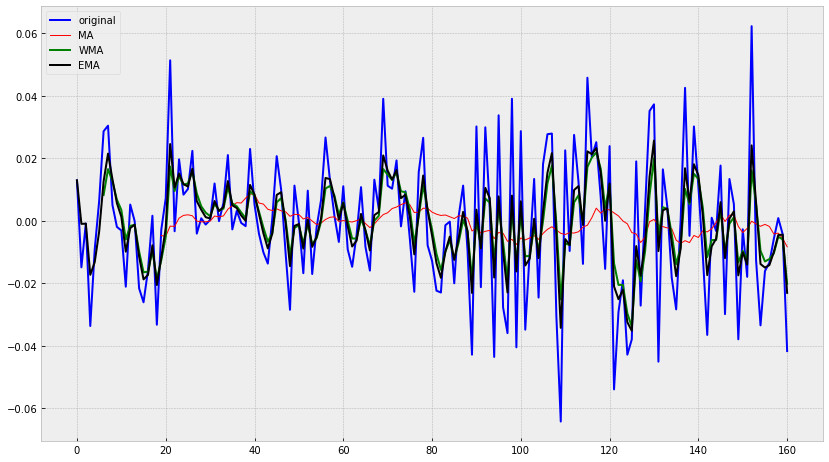

In [68]:
ema = exponential_moving_average(wcDJS, 0.5)
wma = weighted_moving_average(wcDJS, 7, [1,1,2,3,5,8,13])
ma = moving_average(wcDJS, 20)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(wcDJS, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='1', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='2', label='EMA')
    plt.legend()

### Двойное экспоненциальное сглаживание

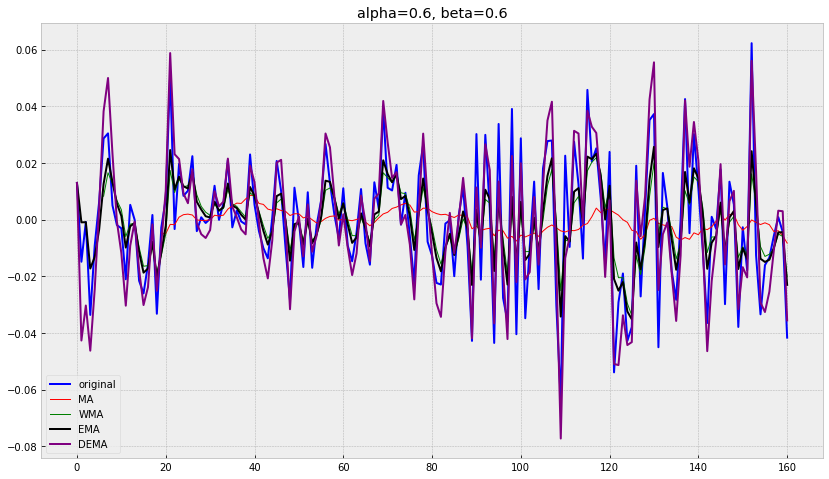

In [69]:
def plot_dema(alpha, beta):
    dema = double_ema(wcDJS, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(wcDJS, color='blue',label='original')
        plt.plot(ma, color='red', linewidth='1', label='MA')
        plt.plot(wma, color='green', linewidth='1', label='WMA')
        plt.plot(ema, color='black', linewidth='2', label='EMA')
        plt.plot(dema, color='purple', linewidth='2', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

plot_dema(0.6, 0.6)

### Хольт - Винтерс

In [70]:
def plot_tema(alpha, beta, gamma, ser=wcDJS, ser_to_plot=wcDJS, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

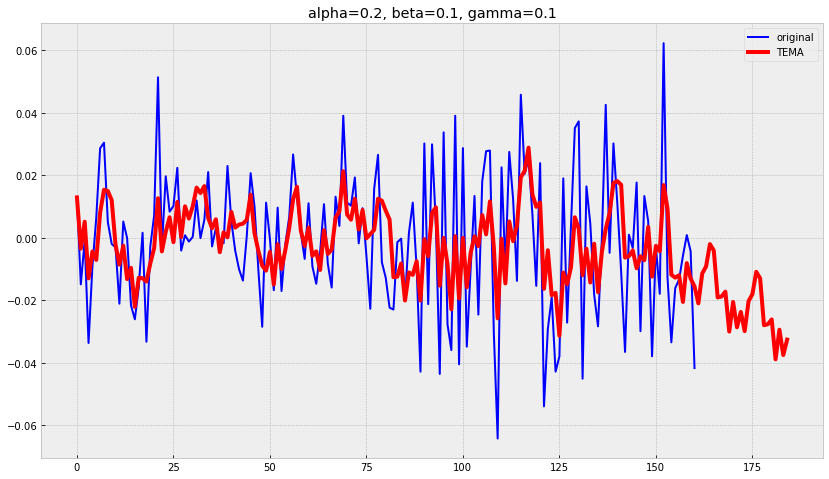

In [71]:
plot_tema(0.2, 0.1, 0.1)

Выбранный ряд - индекс DowJones во время энергетического кризиса в начале 70-х годов, имеет разнаправленный тренд, до ~72г восходящий, после тренд на убывание. Сезонность не прослеживается.  
В не стационарном ряду тройное экспоненциальное сглаживание - Метод Хольта-Винтерса (TEMA), на мой взгляд не особо полезнен, ввиду вышеуказанных факторов. Теоретически полезны экспоненциальное сглаживание, двойное экспоненциальное сглаживание и скользящие средние.  
  
В стационарном ряду, как и пологается, отсутствует сезонность, тренд, но имеются выбросы, оптимальны экспоненциальное сглаживание, двойное экспоненциальное сглаживание.